In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jun 10 15:40:22 2019

@author: athomas7
"""

'\nCreated on Mon Jun 10 15:40:22 2019\n\n@author: athomas7\n'

In [2]:
"""
train_file = "C:/SEPP19/Eye Tracking/Single Eye/train + test.zip"

import zipfile

zf = zipfile.ZipFile(train_file)
zf.extractall()
"""

'\ntrain_file = "C:/SEPP19/Eye Tracking/Single Eye/train + test.zip"\n\nimport zipfile\n\nzf = zipfile.ZipFile(train_file)\nzf.extractall()\n'

In [3]:
%load_ext tensorboard

In [1]:
import os
import cv2
from time import time
from sklearn.model_selection import train_test_split

NB_START_EPOCHS = 100
BATCH_SIZE = 64

def load_image(file_path):
    return cv2.imread(file_path)

def extract_label(file_name):
    return 1 if "open" in file_name else 0 # open eyes are 1 & closed eyes are 0

train_path = "ftrain2/"
image_files = os.listdir(train_path)
train_images = [load_image(train_path + file) for file in image_files]
train_labels = [extract_label(file) for file in image_files]

In [2]:
def deep_model(layer, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model = tf.keras.Sequential(layer)
    model.compile(optimizer='nadam'
                  , loss='sparse_categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history

In [3]:
def eval_metric(model, history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, NB_START_EPOCHS + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()

In [4]:
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

In [5]:
# this will probably not be an issue with the real deal, since all images will be the same size
# so we can re-train with that view from the pilot's eye from the instrument...
def preprocess_image(img, side = 96): # number of pixels on the smallest side
    # average eye aspect ratio is 1.87 by 1 (it requires an int, so I rounded 1.87 to 2)
    eye_aspect_ratio = 2
    min_side = min(img.shape[0], img.shape[1])
    img = img[:min_side, :min_side * eye_aspect_ratio]
    img = cv2.resize(img, (side * eye_aspect_ratio, side)) # average eye aspect ratio of 1.87 by 1
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img / 255.0

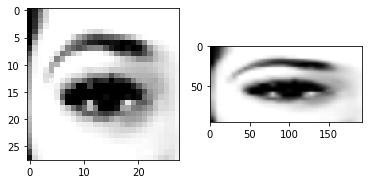

In [6]:
import matplotlib.pyplot as plt
# %matplotlib inline
preview_index = 50
plt.subplot(1,2,1)
plt.imshow(train_images[preview_index])
plt.subplot(1,2,2)
plt.imshow(preprocess_image(train_images[preview_index]), cmap="gray")
# some images are showing up wonky here b/c of your aspect ratio side multiplier ^^^
# it does allow to get the entire eye within the frame though so worth it...
# looks weird to us but the neural net will understand

In [7]:
for i in range(len(train_images)):
    train_images[i] = preprocess_image(train_images[i])

In [8]:
import numpy as np

train_images = np.expand_dims(train_images, axis = -1)
train_labels = np.array(train_labels)

In [9]:
print(train_images.shape, train_labels.shape)

(144, 96, 192, 1) (144,)


In [10]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(train_images, train_labels, test_size=0.2, random_state=37)

In [11]:
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.callbacks import ModelCheckpoint
tensorboard = None
import tensorflow as tf

In [12]:
# Optimizers = ['adam' , 'SGD' , 'RMSprop','adagrad','adadelta','adamax','nadam']
Optimizers = ['adam' , 'adagrad' ,'nadam']
Learning_Rate = [0.001 , 0.005 , 0.01 , 0.05 , 0.1 , 0.5 , 0.9]
Batch_Sizes = [16]
Epoch_Sizes = [15]
Activations = [tf.nn.relu , tf.nn.elu]
Activation_name = ['relu' , 'elu' ]
FilterSizes = [16,32,64,128,256]
Kernel_Size = [3]
PoolSize = [2]
NumberOfHiddenLayer = [1,2,3]
LayersCollection = []
Optimizer_coll = []
activition_coll = []
Batch_size_coll = []
Epoch_size_coll = []
num_hidden_coll = []
K_size = []
Filetersize_coll = []
pool_coll = []
es = EarlyStopping(monitor='val_loss', mode = 'min' ,verbose =1 ,patience=20)

In [53]:
def addFilterAndPool(Layer, Filtersize , ks , PoolSize , y , act):
    count = y
    while count < len(Filtersize):
        Layer.append(tf.keras.layers.Conv2D(filters=Filtersize[count], kernel_size=(ks,ks), padding="same", activation=act, input_shape=train_images.shape[1:]))
        Layer.append(tf.keras.layers.MaxPool2D(pool_size=(PoolSize,PoolSize), strides=(PoolSize,PoolSize)))
        count+=1

In [30]:
def addHiddenLayer(Layer , num , Num_Hidden ,act):
    temp = num*2
    for i in range(Num_Hidden):
        Layer.append(tf.keras.layers.Dense(units=temp , activation =act))
        temp = temp/2
    

In [15]:
n = 0
for i in range(len(Optimizers)):
    for j in range(len(Batch_Sizes)):
        for k in range(len(Epoch_Sizes)):
            for x in range(len(Activations)):
                for Num_Hidden in NumberOfHiddenLayer:
                    for ks in Kernel_Size:
                        for pool in PoolSize:
                            if pool >= ks :
                                break
                            layers = []
                            addFilterAndPool(layers , FilterSizes , ks , pool , 0, Activations[x])
                            layers.append(tf.keras.layers.Flatten())
                            addHiddenLayer(layers , 256 , Num_Hidden ,Activations[x])
                            layers.append(tf.keras.layers.Dense(units=2, activation=tf.nn.softmax)) # probability for each of the classes (2 as of now));
                            LayersCollection.append(layers)

                            #collection inforamtion of each layer for furture reference
                            Optimizer_coll.append(Optimizers[i]) 
                            activition_coll.append(Activation_name[x])
                            Batch_size_coll.append(Batch_Sizes[j])
                            Epoch_size_coll.append(Epoch_Sizes[k])
                            num_hidden_coll.append(Num_Hidden)
                            K_size.append(ks)
                            pool_coll.append(pool)


In [22]:
for i in range(len(Learning_Rate)):
    layers = [
        tf.keras.layers.Conv2D(filters=16, kernel_size=(6,6), padding="same", activation=tf.nn.relu, input_shape=train_images.shape[1:]),
        tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding="same", activation=tf.nn.relu, input_shape=train_images.shape[1:]),
        tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=64,activation=tf.nn.relu),
        tf.keras.layers.Dense(units=2, activation=tf.nn.softmax) # probability for each of the classes (2 as of now)
    ]
    
    LayersCollection.append(layers)

In [43]:
layers = [
        tf.keras.layers.Conv2D(filters=16, kernel_size=(6,6), padding="same", activation=tf.nn.relu, input_shape=train_images.shape[1:]),
        tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding="same", activation=tf.nn.relu, input_shape=train_images.shape[1:]),
        tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=64,activation=tf.nn.relu),
        tf.keras.layers.Dense(units=2, activation=tf.nn.softmax) # probability for each of the classes (2 as of now)
    ]
LayersCollection.clear()
LayersCollection.append(layers)

In [44]:
print(len(LayersCollection))
print(len(Optimizer_coll))
print(len(activition_coll))
print(len(Batch_size_coll))
print(len(Epoch_size_coll))
print(len(num_hidden_coll))
print(len(K_size))
print(len(pool_coll))

1
0
0
0
0
0
0
0


In [ ]:
# # https://keras.io/optimizers/ (see Adam section)
# # https://keras.io/losses/ (see sparse_categorical_accuracy)
# model = tf.keras.Sequential(layers)
# model.compile(optimizer='adam',
#               # optimizer=tf.keras.optimizers.Adam(),
#               # loss='binary_crossentropy',
#               # loss=tf.losses.sparse_softmax_cross_entropy(),
#               # loss=tf.keras.backend.sparse_categorical_crossentropy(),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
#               # metrics=[tf.metrics.accuracy()])
# """ TensorFlow 2.0.0 Beta
# model.compile(optimizer=tf.optimizers.Adam(),
#               loss=tf.losses.SparseCategoricalCrossentropy(),
#               metrics=[tf.metrics.SparseCategoricalAccuracy()])
# """
# tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

Minimum validation loss reached in epoch 36


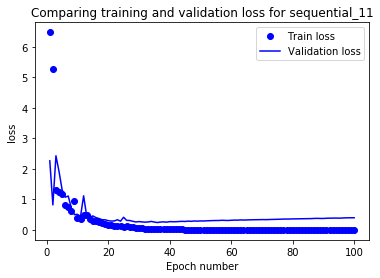

In [66]:
model = tf.keras.Sequential(LayersCollection[0])
model.compile(optimizer='nadam'
                , loss='sparse_categorical_crossentropy'
                , metrics=['accuracy'])
    
history = model.fit(X_train_rest
                    , y_train_rest
                    , epochs=100
                    , batch_size=BATCH_SIZE
                    , validation_data=(X_valid, y_valid)
                    , verbose=0
#                    , callbacks=[es]
         )
base_min = optimal_epoch(history)
eval_metric(model, history, 'loss')

In [45]:
i = 0
models = []

for layer in LayersCollection:
    # https://keras.io/optimizers/ (see Adam section)
    # https://keras.io/losses/ (see sparse_categorical_accuracy)
    model = tf.keras.Sequential(layer)
    model.compile(optimizer='nadam',
                    # optimizer=tf.keras.optimizers.Adam(),
                    # loss='binary_crossentropy',
                    # loss=tf.losses.sparse_softmax_cross_entropy(),
                    # loss=tf.keras.backend.sparse_categorical_crossentropy(),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
                    # metrics=[tf.metrics.accuracy()])
    """ TensorFlow 2.0.0 Beta
    model.compile(optimizer=tf.optimizers.Adam(),
                    loss=tf.losses.SparseCategoricalCrossentropy(),
                    metrics=[tf.metrics.SparseCategoricalAccuracy()])
    """
    models.append(model)
#     print(Optimizer_coll[i])
#     print(activition_coll[i])
#     print(Batch_size_coll[i])
#     print(Epoch_size_coll[i])
#     print(num_hidden_coll[i])
#     print(pool_coll[i])

#     name = "logs/OpenClosedEye_" + Optimizer_coll[i] + activition_coll[i]+ str(i);  
#     tensorboard = TensorBoard(log_dir=name)
#     model.fit(train_images, train_labels, epochs=Epoch_size_coll[i], batch_size=Batch_size_coll[i] , callbacks=[tensorboard])
#    model.save("model"+str(i)+".h5")
#     i+=1

In [46]:

model.optimizer.lr = 0.001

In [47]:
# Training the model
import time
i = 0
for model in models:
#     name = "logs/OpenClosedEye_with_Batchsize" + str(i)
#     tensorboard = TensorBoard(log_dir=name)
    model.fit(train_images, train_labels, epochs=30, batch_size=16 ,validation_data=(X_valid, y_valid), callbacks=[es])
    i = i+1
#    model.save_weights("model_currentbest"+"tf")
    model.save("model_currentbest"+".h5")

Train on 144 samples, validate on 29 samples
Epoch 1/30
144/144 [==============================] - 3s 21ms/sample - loss: 0.9163 - accuracy: 0.5764 - val_loss: 0.5955 - val_accuracy: 0.5517
Epoch 2/30
144/144 [==============================] - 2s 14ms/sample - loss: 0.4575 - accuracy: 0.8125 - val_loss: 0.2850 - val_accuracy: 0.8966
Epoch 3/30
144/144 [==============================] - 2s 14ms/sample - loss: 0.3719 - accuracy: 0.8542 - val_loss: 0.1392 - val_accuracy: 1.0000
Epoch 4/30
144/144 [==============================] - 2s 16ms/sample - loss: 0.2424 - accuracy: 0.9097 - val_loss: 0.0993 - val_accuracy: 1.0000
Epoch 5/30
144/144 [==============================] - 2s 14ms/sample - loss: 0.1551 - accuracy: 0.9583 - val_loss: 0.0627 - val_accuracy: 1.0000
Epoch 6/30
144/144 [==============================] - 2s 15ms/sample - loss: 0.1053 - accuracy: 0.9722 - val_loss: 0.0301 - val_accuracy: 1.0000
Epoch 7/30
144/144 [==============================] - 2s 14ms/sample - loss: 0.0733 -

In [14]:
%tensorboard --logdir logs

In [93]:
import pickle
import cv2

test_file = "closed_eye_75.jpg"
uploads = cv2.imread("test/" + test_file)

""" For Multiple Images...
import glob
import cv2
images = [cv2.imread(file) for file in glob.glob("path/to/files/*.png")]
"""

eval_images = [preprocess_image(uploads)] # must be an array because of the for-loop below
# eval_images = [preprocess_image(load_image(file)) for file in uploads].keys()]
eval_model = tf.keras.Sequential(LayersCollection[0])
eval_model.load_weights("model0.h5")
eval_predictions = eval_model.predict(np.expand_dims(eval_images, axis = -1))

cols = 4
rows = np.ceil(len(eval_images)/cols)
fig = plt.gcf()
fig.set_size_inches(cols*4, rows*4)
for i in range(len(eval_images)):
    plt.subplot(rows, cols, i+1)
    plt.imshow(eval_images[i], cmap="gray")
    plt.title("Open" if np.argmax(eval_predictions[i])==1 else "Closed")
    plt.axis('off')

OSError: Unable to open file (unable to open file: name = 'model0.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [25]:
test_path = "gabor/gabor50-0_test/"
test_files = os.listdir(test_path)
test_images = [load_image(test_path + file) for file in test_files]
test_labels = [extract_label(file) for file in test_files]

# eval_model = tf.keras.Sequential(layers)
# eval_model.load_weights("model.h5")

import time

above = []
lantancys = []
accur = []

j = 0

for f in range(len(Optimizers)):
    for a in range(len(Batch_Sizes)):
        for k in range(len(Epoch_Sizes)):
            for x in range(len(Activations)):
                for Num_Hidden in NumberOfHiddenLayer:
                    for ks in Kernel_Size:
                        for pool in PoolSize:
                            right = 0
                            total = 0
                            for i in range(len(test_images)):
                                temp = test_images[i]
                                temp = [preprocess_image(temp)]
                                begin_time = int(round(time.time() * 1000))
                                eval_model = models[x]
                                eval_predictions = eval_model.predict(np.expand_dims(temp , axis= -1))
                                end_time = int(round(time.time() * 1000))
                                if (test_labels[i] == 1 and np.argmax(eval_predictions[0])==1) or (test_labels[i] == 0 and np.argmax(eval_predictions[0])!=1):
                                    right+=1
                                total+= end_time-begin_time

                            print("accuracy for ",j," is :",right/64*100 , "%")
                            print("time spent for " ,j, " is : " , total , "ms")
                            j = j +1
                            above.append(x)
                            lantancys.append(total)
                            accur.append(right/64*100)


NameError: name 'models' is not defined

## test_path = "gabor/gabor50-45_test/"
test_files = os.listdir(test_path)
test_images = [load_image(test_path + file) for file in test_files]
test_labels = [extract_label(file) for file in test_files]

# eval_model = tf.keras.Sequential(layers)
# eval_model.load_weights("model.h5")

import time

above = []
lantancys = []
accur = []

j = 0
right = 0
total = 0
for i in range(len(test_images)):
    temp = test_images[i]
    temp = [preprocess_image(temp)]
    begin_time = int(round(time.time() * 1000))
    eval_model = model
    eval_predictions = eval_model.predict(np.expand_dims(temp , axis= -1))
    end_time = int(round(time.time() * 1000))
    if (test_labels[i] == 1 and np.argmax(eval_predictions[0])==1) or (test_labels[i] == 0 and np.argmax(eval_predictions[0])!=1):
        right+=1
    total+= end_time-begin_time

print("accuracy for ",j," is :",right/64*100 , "%")
print("time spent for " ,j, " is : " , total , "ms")

# test_path = "gabor/gabor100-45_test/"
test_files = os.listdir(test_path)
test_images = [load_image(test_path + file) for file in test_files]
test_labels = [extract_label(file) for file in test_files]

# eval_model = tf.keras.Sequential(layers)
# eval_model.load_weights("model.h5")

import time

above = []
lantancys = []
accur = []

j = 0
right = 0
total = 0
for i in range(len(test_images)):
    temp = test_images[i]
    temp = [preprocess_image(temp)]
    begin_time = int(round(time.time() * 1000))
    eval_model = model
    eval_predictions = eval_model.predict(np.expand_dims(temp , axis= -1))
    end_time = int(round(time.time() * 1000))
    if (test_labels[i] == 1 and np.argmax(eval_predictions[0])==1) or (test_labels[i] == 0 and np.argmax(eval_predictions[0])!=1):
        right+=1
    total+= end_time-begin_time

print("accuracy for ",j," is :",right/64*100 , "%")
print("time spent for " ,j, " is : " , total , "ms")

In [48]:
test_path = "ftest2/"
test_files = os.listdir(test_path)
test_images = [load_image(test_path + file) for file in test_files]
test_labels = [extract_label(file) for file in test_files]

# eval_model = tf.keras.Sequential(layers)
# eval_model.load_weights("model.h5")

import time

above = []
lantancys = []
accur = []

j = 0
right = 0
total = 0
k = 0
for model in models:
    for i in range(len(test_images)):
        temp = test_images[i]
        temp = [preprocess_image(temp)]
        begin_time = int(round(time.time() * 1000))
        eval_model = model
        eval_predictions = eval_model.predict(np.expand_dims(temp , axis= -1))
        end_time = int(round(time.time() * 1000))
        if (test_labels[i] == 1 and np.argmax(eval_predictions[0])==1) or (test_labels[i] == 0 and np.argmax(eval_predictions[0])!=1):
            right+=1
        total+= end_time-begin_time

    print("accuracy for Learning rate ",Learning_Rate[k] ," is :",right/64*100 , "%")
    print("time spent for ",Learning_Rate[k], " is : " , total , "ms")
    right = 0
    total = 0
    k = k +1

accuracy for Learning rate  0.001  is : 93.75 %
time spent for  0.001  is :  1701 ms


In [ ]:
# Optimizer_coll = []
# activition_coll = []
# Batch_size_coll = []
# Epoch_size_coll = []
# num_hidden_coll = []
# Filetersize_coll = []
# pool_coll = []

In [25]:
print(above)

[3, 6, 8, 9, 15, 19, 20, 24, 26, 27, 30, 31, 33, 34, 37, 39, 40, 41, 42, 43, 45, 48, 49]


In [34]:
for i , j , k in zip(above, lantancys , accur):
    print("optmizer:" , Optimizer_coll[i] , ",Activition function:", activition_coll[i] , ",Num of hiddenlayer:" , num_hidden_coll[i] ,",Kernel size: ", K_size[i] , " with lantancys :" , j/64 , "ms", "  ,accurancy: " , k , "%")

optmizer: adam ,Activition function: relu ,Num of hiddenlayer: 2 ,Kernel size:  3  with lantancys : 28.609375 ms   ,accurancy:  98.4375 %
optmizer: adam ,Activition function: relu ,Num of hiddenlayer: 3 ,Kernel size:  3  with lantancys : 28.453125 ms   ,accurancy:  98.4375 %
optmizer: adam ,Activition function: relu ,Num of hiddenlayer: 3 ,Kernel size:  5  with lantancys : 31.6875 ms   ,accurancy:  100.0 %
optmizer: adam ,Activition function: elu ,Num of hiddenlayer: 1 ,Kernel size:  3  with lantancys : 28.53125 ms   ,accurancy:  98.4375 %
optmizer: adam ,Activition function: elu ,Num of hiddenlayer: 3 ,Kernel size:  3  with lantancys : 29.03125 ms   ,accurancy:  100.0 %
optmizer: adagrad ,Activition function: relu ,Num of hiddenlayer: 1 ,Kernel size:  4  with lantancys : 29.515625 ms   ,accurancy:  98.4375 %
optmizer: adagrad ,Activition function: relu ,Num of hiddenlayer: 1 ,Kernel size:  5  with lantancys : 31.78125 ms   ,accurancy:  98.4375 %
optmizer: adagrad ,Activition function:

In [ ]:
print(train_labels)

In [ ]:
import numpy as np
img_arr = np.array(preprocess_image(uploads))
print(len(img_arr.flatten()))